# Deep Learning
### Week 2: Multilayer perceptrons

## Contents
[1. Introduction](#introduction)

[2. Mathematical neuron (\*)](#neuron)

[3. Stochastic gradient descent](#sgd)

[4. Multilayer perceptrons](#mlp)

[5. The Sequential class (\*)](#sequential)

[References](#references)

<a class="anchor" id="introduction"></a>
## Introduction

In the last week of the module we reviewed some important concepts in machine learning, including generalisation, validation, dataset splits, overfitting/underfitting and regularisation. We also took a look at the most fundamental building blocks and operations in TensorFlow. You saw how the low level objects Tensors and Variables are included in these models to encapsulate mutable parameters and computational operations.

This week, we will introduce the concept of the artifical neuron, and define the simplest of deep learning architectures; the multilayer perceptron (MLP) or feedforward network. We will review the stochastic gradient descent algorithm that is commonly used to train neural network models.

We will see how to build and train MLP models in TensorFlow, using the Sequential API. These MLP models can be constructed from Dense layer objects, which inherit from the base Layer class in TensorFlow. We will also see how we can write our own custom Layer objects by subclassing the base Layer class.

<a class="anchor" id="neuron"></a>
## Mathematical neuron
Early research into neural networks focused on models of learning in the brain, and used mathematical (or artificial) neurons as fundamental building blocks. These are simple models of neurons in the brain, that receive a set of inputs, which are weighted and summed before being passed through an activation function (or transfer function):

$$
\begin{equation}
y_k = \sigma\left(\sum_j w_{kj}x_j + b_k\right) \tag{4}
\end{equation}
$$

<img src="figures/mathematical_neuron.png" alt="Artificial neuron" style="width: 500px;"/>
<center>Sketch of a mathematical neuron.</center>

<img src="figures/biological_neuron.png" alt="Biological neuron" style="width: 500px;"/>
<center>Sketch of a biological neuron. Source: <a href="https://en.wikipedia.org/wiki/Neuron">Wikipedia</a>.</center>

In the above, the inputs to the neuron are denoted by $x_j$, the weights $w_{kj}$, bias $b_k$ and activation function $\sigma$. The weights and bias are parameters that need to be tuned for the given task. The first artificial neuron was developed by [McCulloch and Pitts](#McCullochPitts43), which used a simple threshold activation function (step function) only on binary inputs, and produce a binary output. Later, [Rosenblatt](#Rosenblatt58) developed the **perceptron**, which also used a step function threshold for binary classification (but with more general weights and inputs), and importantly also introduced a learning algorithm for the weights. The perceptron learning algorithm is guaranteed to converge for linearly separable data. However, the limitations of linear models was largely responsible for the decline in interest in neural networks until its revival in the 1980s.

#### McCulloch-Pitts neuron
As an example, we will use Tensors to implement the McCulloch-Pitts neuron for a simple logical function. The McCulloch-Pitts neuron operates on boolean inputs, and uses a threshold activation to produce a boolean output. The function can be written as

$$
f(\mathbf{x}) = 
\begin{cases}
1 \quad \text{if } \sum_i x_i \ge b\\
0 \quad \text{if } \sum_i x_i < b
\end{cases}
$$

In [1]:
import tensorflow as tf

2024-01-26 11:17:37.959957: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# Define the AND function

def logical_and(x):
    #tf.shape is a tensor containing the shape of the input, eg the input is a tensor of shape [2,3] so shape is the tensor
    #[2,3] of shape (2,)
    
    #checks if the sum of the x (reduce) is greater than or equal to the product of the shape
    #if not, then there is a 0 in the matrix, hence outputs 0
    #result is casted to integer
    return tf.cast(tf.math.greater_equal(tf.reduce_sum(x), tf.reduce_prod(tf.shape(x))), tf.int32)


In [3]:
# Test the AND function with a few examples
logical_and(tf.ones((2, 3), dtype=tf.int32))


<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [4]:
# Define the OR function
def logical_or(x):
    
    #if the sum is at least 1, then the or is fullfilled
    return tf.cast(tf.math.greater_equal(tf.reduce_sum(x), 1), tf.int32)


In [5]:
# Test the OR function with a few examples
logical_or(tf.zeros(3,))


<tf.Tensor: shape=(), dtype=int32, numpy=0>

*Exercise.* Define the function for the NOR operation below (all inputs must be zero) for inputs `x`. *Hint: use the* `tf.math.logical_not` *function.*

In [6]:
# Define the NOR function

def logical_nor(x):
    #if we want all inputs to be 0, then we want it to return 1 if not(all inputs are 1)
    return tf.cast(tf.math.logical_not(tf.math.greater_equal(tf.reduce_sum(x), 1)),tf.int32)

In [8]:
# Test the NOR function with a few examples

print(logical_nor(tf.constant([1, 0])))  # False
print(logical_nor(tf.constant([0, 0])))  # True
print(logical_nor(tf.constant([0, 0, 0])))  # True
print(logical_nor(tf.constant([1, 0, 1])))  # False

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)


#### The perceptron
The perceptron is also a linear binary classifier, but with more flexible weights. It can be written as the following function

$$
f(\mathbf{x}) = 
\begin{cases}
1 \quad \text{if } \sum_i w_i x_i + b \ge 0\\
0 \quad \text{if } \sum_i w_i x_i + b < 0
\end{cases}
$$

As an example, we will use Tensors and Variables to implement the perceptron classifier.

In [7]:
# Implement the weights and bias as Variables
#recall variable as we want to be able to change it 
weights = tf.Variable(tf.constant([1.,0.5]),name = "weights")
bias = tf.Variable(tf.constant(-0.5), name = "bias")


In [8]:
# Define the perceptron classifier
#technically is an activation function but is a step function
def perceptron(x):
    return tf.math.greater_equal(tf.tensordot(x, weights, axes=1) + bias, 0)

In [9]:
# Create a random set of test points
x = tf.random.normal((100,2))
#will output a vector of true false since we have 100 x cases
perceptron(x)


<tf.Tensor: shape=(100,), dtype=bool, numpy=
array([ True,  True,  True,  True, False, False, False,  True,  True,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False,  True, False, False,  True, False, False,
       False, False, False,  True,  True, False,  True,  True, False,
       False, False,  True, False, False,  True, False,  True, False,
       False,  True, False, False, False,  True,  True, False, False,
        True, False, False,  True,  True, False, False, False, False,
        True, False,  True, False, False, False,  True,  True, False,
       False,  True,  True, False,  True, False, False,  True, False,
        True, False, False, False,  True,  True, False, False, False,
        True, False,  True,  True, False, False,  True, False, False,
        True])>

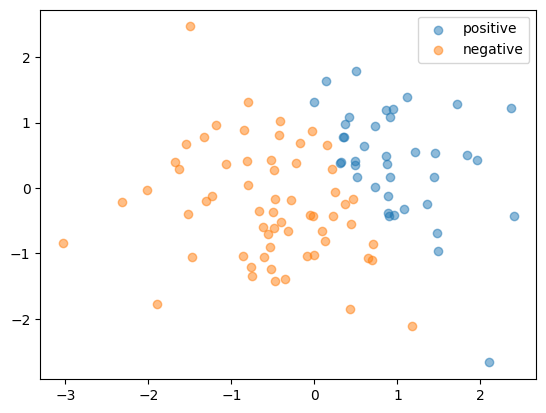

In [10]:
# Plot the points coloured by class prediction
import matplotlib.pyplot as plt

preds = perceptron(x)
positive = x[preds]
negative = x[~preds]
plt.scatter(positive[:,0], positive[:,1], alpha = 0.5, label = "positive")
plt.scatter(negative[:,0], negative[:,1], alpha = 0.5, label = "negative")
plt.legend()
plt.show()


In [ ]:
# Update the weights and bias and re-plot

#this is where we would just change them and see the boundary change


*Exercise.* Can you find weights and bias values to implement the NOT gate for $x\in\{0, 1\}$ and the XOR gate for $x\in\{0, 1\}^2$? If yes, what are the values? If no, why not?

<a class="anchor" id="sgd"></a>
## Stochastic gradient descent

The second wave of interest in neural networks in the 80s was driven in large part by the connectionist movement (see e.g. [Rumelhart et al (1986a)](#Rumelhart86a)), which focused on the concept of intelligent behaviour arising out of many simple computations composed together, with knowledge being distributed across many units. Smooth activation functions were increasingly studied, as they allowed gradient-based methods such as stochastic gradient descent (SGD, [Robbins & Monro 1951](#Robbins51)) to be used in the optimisation of model parameters. 

#### Activation functions
A typical example of a smooth activation function is the logistic sigmoid:

In [56]:
import tensorflow as tf

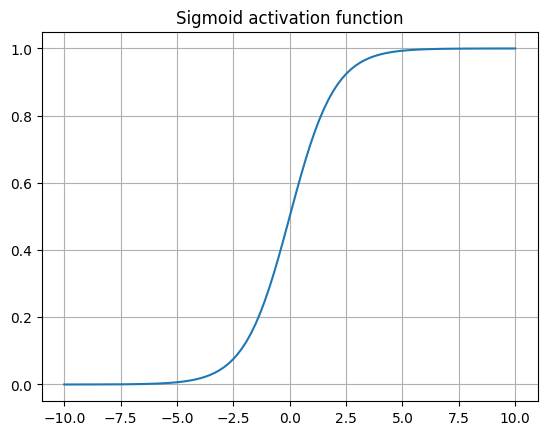

In [11]:
# Plot the sigmoid function using the TensorFlow implementation

import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, 100)
y = tf.keras.activations.sigmoid(x)
plt.grid()
plt.plot(x, y)
plt.title("Sigmoid activation function")
plt.show()

Note that linear regression and logistic regression can both be viewed as artificial neuron models, with linear (or no) activation function and sigmoid activation function respectively.

Other activation functions that are commonly used in deep learning models are the ReLU (rectified linear unit), tanh, ELU (exponential linear unit, [Clevert et al 2016](#Clevert16)), SELU (scaled exponential linear unit, [Klambauer et al 2017](#Klambauer17)), softplus, swish ([Ramachandran et al 2018](#Ramachandran18)).

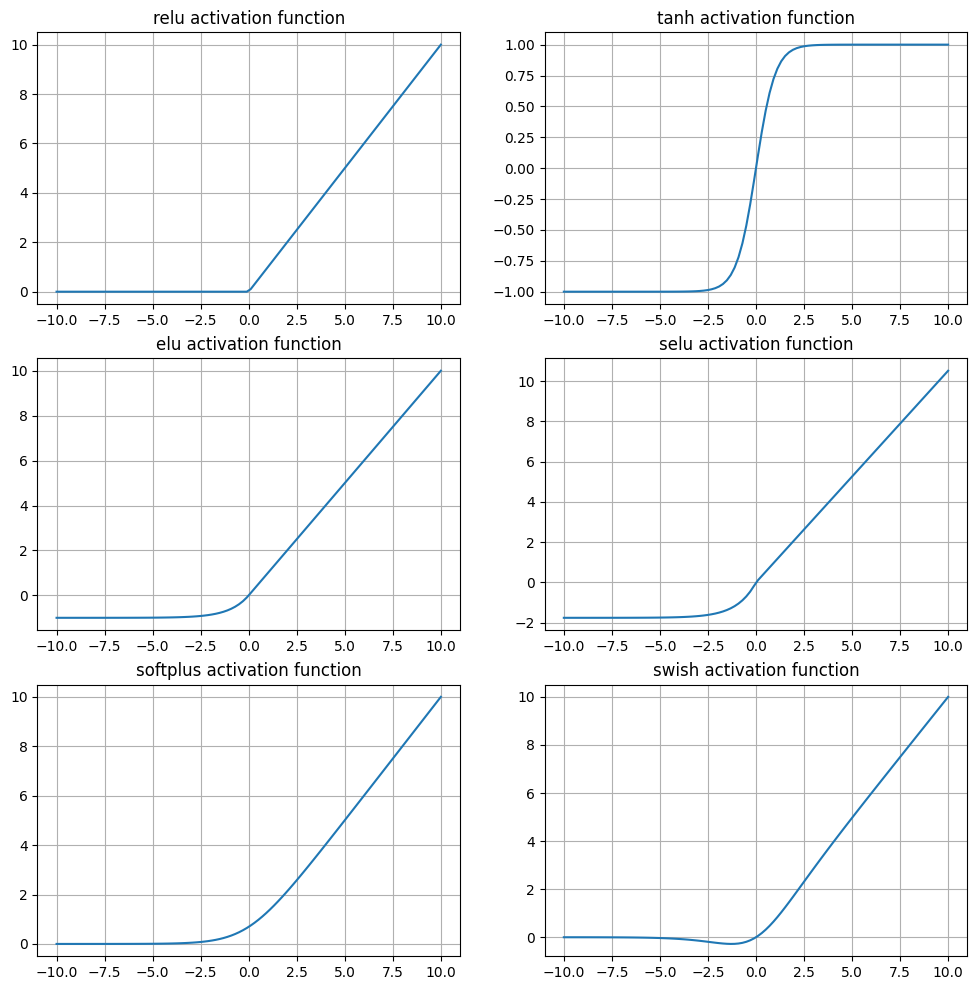

In [12]:
# Plot example activation functions

x = np.linspace(-10, 10, 100)
fig = plt.figure(figsize=(12, 12))
for i, activation in enumerate(['relu', 'tanh', 'elu', 'selu', 'softplus', 'swish']):
    row = (i % 2) + 1
    col = (i // 2) + 1
    fig.add_subplot(3, 2, i + 1)
    plt.grid()
    plt.title("{} activation function".format(activation))
    plt.plot(x, getattr(tf.keras.activations, activation)(x))
plt.show()

You can see a complete list of available activation functions in `tf.keras.activations` [here](https://www.tensorflow.org/api_docs/python/tf/keras/activations).

#### Gradient descent

Suppose we have constructed our neural network model, which we represent as the function $f_\theta:\mathbb{R}^D\mapsto Y$, where $Y$ is the target space (e.g. $\mathbb{R}$ or $[0, 1]$). Suppose also that we have defined a suitable loss function 

$$
L(\theta; \mathcal{D}_{train}) := \frac{1}{|\mathcal{D}_{train}|} \sum_{x_i, y_i\in\mathcal{D}_{train}} l(y_i, f_\theta(x_i)),
$$

where $l(y_i, f_\theta(x_i))$ is the per-example loss. Then the gradient $\nabla_\theta L (\theta_0; \mathcal{D}_{train})$ evaluated at $\theta_0$ defines the direction of steepest ascent in parameter space at the point $\theta$. 

The gradient descent algorithm takes an initial guess for the parameters $\theta_0$ and updates the parameter values according to the rule

$$
\theta_{t+1} = \theta_{t} - \eta \nabla_\theta L(\theta_t; \mathcal{D}_{train}),\qquad t\in\mathbb{N}_0
$$

where $\eta_t>0$ is a small learning rate which may depend on $t$. For a suitably chosen $\eta_t$, the iterates $L(\theta_t; \mathcal{D}_{train})$, $t\in\mathbb{N}_0$ converge to a local minimum.

#### Stochastic gradient descent

Note that computing $\nabla_\theta L(\theta; \mathcal{D}_{train})$ as above requires computing the gradients of the per-example loss for every element in the training set. For large datasets (and large models) this can be prohibitively expensive. 

Stochastic gradient descent provides a cheaper estimate of the full gradient, by computing the gradient on a minibatch of data points, instead of the full dataset. In particular, we evaluate the gradient 

$$
L(\theta; \mathcal{D}_m) = \frac{1}{M} \sum_{x_i, y_i\in\mathcal{D}_m} l(y_i, f_\theta(x_i)),
$$

where $\mathcal{D}_m$ is a randomly sampled minibatch of training data points, $M = |\mathcal{D}_m|$ is the size of the minibatch (typically much smaller than $|\mathcal{D}_{train}|$). We then use the gradient $\nabla_\theta L(\theta_t; \mathcal{D}_m)$ to update the parameters

$$
\theta_{t+1} = \theta_{t} - \eta \nabla_\theta L(\theta_t; \mathcal{D}_m),\qquad t\in\mathbb{N}_0
$$

This update provides a stochastic approximation to the true gradient which is far more efficient to compute, and provides a huge speed up in the training process for large datasets.

<a class="anchor" id="mlp"></a>
## Multilayer perceptrons

The simplest type of deep learning model is the **multilayer perceptron**, also known as a **feedforward network**. This type of neural network can be viewed as an architecture consisting of layers of mathematical neurons, linked together in a directed acyclic graph.

#### MLP with single hidden layer
A key property of deep learning models is the fact that they are _compositional_ instead of _additive_. Where as linear regression models (or logistic regression, kernel regression) increase complexity by adding extra basis functions $\phi_i$ in the expansion

$$
f(\mathbf{x}) = \sum_{i} w_i \phi_i(\mathbf{x}),
$$

deep learning models increase complexity by composing multiple simple functions $\varphi_k$ together:

$$
f(\mathbf{x}) = \varphi_L(\varphi_{L-1}(\ldots\varphi_2(\varphi_1(\mathbf{x}))\ldots )).
$$

The functions $\varphi_k$ are defined to be affine transformations followed by an element-wise activation function. An example is the MLP with a single hidden layer: 

$$
\begin{align}
h_j^{(1)} &= \sigma\left( \sum_{i=1}^D w^{(0)}_{ji}x_i + b_j^{(0)} \right),\qquad j=1,\ldots,n_h, \tag{5}\\
\hat{y} &= \sigma_{out}\left( \sum_{i=1}^{n_h} w^{(1)}_{i}h^{(1)}_i + b^{(1)} \right). \tag{6}\\
\end{align}
$$

In the above, $\mathbf{x}\in\mathbb{R}^D$ is an example input, $n_h\in\mathbb{N}$ is the number of hidden units in the network, $\sigma, \sigma_{out}:\mathbb{R}\mapsto\mathbb{R}$ are activation functions, $w^{(0)}_{ji}\in\mathbb{R}$ and $w^{(1)}_{ji}\in\mathbb{R}$ are weights, and $b_j^{(0)}\in\mathbb{R}$ and $b^{(1)}\in\mathbb{R}$ are biases.

Following (5) and (6) we also define the **pre-activations** $a_j^{(1)} := \sum_{i=1}^D w^{(0)}_{ji}x_i + b_j^{(0)}$. Correspondingly, the $h_j^{(1)}$ are referred to as the **post-activations** (or frequently, just **activations**).

This construction can be summarised in the following diagram.

<img src="figures/ann_single_hidden_layer_outline.png" alt="MLP with a single hidden layer" style="width: 500px;"/>
<center>Multilayer perceptron with a single hidden layer consisting of three neurons.</center>

We will usually write equations (5) and (6) in the more concise form:

$$
\begin{align}
\mathbf{h}^{(1)} &= \sigma\left( \mathbf{W}^{(0)}\mathbf{x} + \mathbf{b}^{(0)} \right),\tag{7}\\
\hat{y} &= \sigma_{out}\left( \mathbf{w}^{(1)}\mathbf{h}^{(1)} + b^{(1)} \right), \tag{8}
\end{align}
$$

where $\mathbf{x}\in\mathbb{R}^D$, $\mathbf{W}^{(0)}\in\mathbb{R}^{n_h\times D}$, $\mathbf{b}^{(0)}\in\mathbb{R}^{n_h}$, $\mathbf{h}^{(1)}\in\mathbb{R}^{n_h}$, $\mathbf{w}^{(1)}\in\mathbb{R}^{1\times n_h}$, $b^{(1)}\in\mathbb{R}$ and we overload notation with the activation functions $\sigma, \sigma_{out}: \mathbb{R}\mapsto\mathbb{R}$ by applying them element-wise in the above.

This hidden layer is a type of neural network layer that is often referred to as a **dense** or **fully connected** layer.

#### MLP with multiple hidden layers
More generally, for an MLP with $L$ hidden layers, we have

$$
\begin{align}
\mathbf{h}^{(0)} &:= \mathbf{x}, \tag{9}\\
\mathbf{h}^{(k)} &= \sigma\left( \mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)} \right),\qquad k=1,\ldots, L,\tag{10}\\
\hat{y} &= \sigma_{out}\left( \mathbf{w}^{(L)}\mathbf{h}^{(L)} + b^{(L)} \right), \tag{11}
\end{align}
$$

where $\mathbf{W}^{(k)}\in\mathbb{R}^{n_{k+1}\times n_k}$, $\mathbf{b}^{(k)}\in\mathbb{R}^{n_{k+1}}$, $\mathbf{h}^{(k)}\in\mathbb{R}^{n_k}$, and we have set $n_0 := D$, and $n_k$ is the number of units in the $k$-th hidden layer.

The following diagram shows the MLP architecture with two hidden layers.

<img src="figures/ann_two_hidden_layers.png" alt="MLP with a two hidden layers" style="width: 700px;"/>
<center>Multilayer perceptron with a two hidden layers.</center>

The hidden layers inside a deep network can be viewed as *learned feature extractors*. The weights of the network learn to encode the data in such a way as to represent progressively more complex or abstract features of the data that are useful for solving the problem task at hand. This hierarchy of representations is a core property of the expressive power of deep learning models ([Rumelhart et al 1986b](#Rumelhart86b)).

#### Output layers
One of the strengths of deep learning models is their applicability to a wide range of dataset types and problem tasks. In equation (11) we have considered a single unit output $y$, which is produced by passing the pre-activation $a^{(L+1)} := \mathbf{w}^{(L)}\mathbf{h}^{(L)} + b^{(L)}$ through the activation function $\sigma_{out}$. 

Note how linear regression and logistic regression can both be viewed as a neural network without a hidden layer. In this case, if $\sigma_{out}$ is be the identity (or linear) activation, then we are left with a simple linear regression model. Likewise, if $\sigma_{out}$ is the sigmoid function, then we have the logistic regression model.

The architecture can also be easily modified to output multiple target variables $\hat{\mathbf{y}}$ by replacing (11) with $\hat{\mathbf{y}} = \sigma_{out}\left( \mathbf{W}^{(L+1)}\mathbf{h}^{(L)} + \mathbf{b}^{(L+1)} \right)$:

<img src="figures/ann_with_two_hidden_layers_multioutput.png" alt="MLP with a two hidden layers" style="width: 700px;"/>
<center>Multilayer perceptron with multiple outputs.</center>

Moreover, the activation functions in the output layer can be chosen according to the requirements of the target variables. For example, if the network should output an estimate for a standard deviation parameter, then we will want to constrain the output to be positive. This can be achieved by passing the pre-activation through a softplus or exponential activation function, for example. It is common for a sigmoid activation to be used where the output should be interpreted as a probability (as in logistic regression). More generally, for target variables that should be constrained to an interval, then a sigmoid or tanh activation can be used followed by a suitable rescaling. Different activation functions could be applied to different units in the output layer, if appropriate.

Another common output layer is the **softmax**, which is used for multiclass classification models. The softmax layer outputs a normalised array, which can be interpreted as a probability vector specifying a categorical distribution. For pre-activations

$$
\mathbf{a}^{(L+1)} := \mathbf{W}^{(L)}\mathbf{h}^{(L)} + \mathbf{b}^{(L)}
$$

with $\mathbf{W}^{(L)}\in\mathbb{R}^{C \times n_L}$, $\mathbf{b}^{(L)}\in\mathbb{R}^C$ where $C$ is the number of classes, the softmax function is given by

$$
\hat{\mathbf{y}}_j := \text{softmax}(\mathbf{a}^{(L+1)})_j = \frac{\exp (a_j)}{\sum_i \exp (a_i)}.
$$

Note that the softmax function operates on all pre-activations in the output layer, in contrast to the usual element-wise application of most activation functions.

<img src="figures/ann_with_softmax_output.png" alt="MLP with a softmax output." style="width: 700px;"/>
<center>Multilayer perceptron with a softmax output layer.</center>

<a class="anchor" id="sequential"></a>
## The Sequential class

There are multiple ways to build and apply deep learning models in Tensorflow, from high-level, quick and easy-to-use APIs, to low-level operations. In this section you will walk through the high-level Keras API for quickly building, training, evaluating and predicting from deep learning models. In particular, you will see how to use the `Sequential` class to implement MLP models.

tf.Tensor(
[[-1.5420434  1.4820511  2.5338764]
 [ 0.         0.         0.       ]], shape=(2, 3), dtype=float32)
[<tensorflow.python.keras.layers.core.Dense object at 0x000002F2326E7D50>, <tensorflow.python.keras.layers.core.Dense object at 0x000002F234A69010>, <tensorflow.python.keras.layers.core.Dense object at 0x000002F234A69BD0>]
<tf.Variable 'dense_22/kernel:0' shape=(4, 4) dtype=float32, numpy=
array([[-0.36219245, -0.04705393,  0.26654655, -0.20252645],
       [-0.820984  , -0.8378717 , -0.82149565, -0.7082558 ],
       [ 0.221762  ,  0.8014994 ,  0.82586616, -0.47599718],
       [ 0.80620354,  0.4749053 , -0.6361507 , -0.64164174]],
      dtype=float32)>
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (2, 4)                    28        
_________________________________________________________________
dense_22 (Dense)             (2, 4)       

#### The `Dense` layer

We will see how to build MLP models using the `Dense` layer class from TensorFlow. This class implements the layer transformation $
\mathbf{h}^{(k+1)} = \sigma\left( \mathbf{W}^{(k)}\mathbf{h}^{(k)} + \mathbf{b}^{(k)} \right)
$.

In [25]:
# Create a Dense layer
from keras.layers import Dense      

#we dont have to have the layer specifically in the sequential class we can have them as individual objects
dense_layer = Dense(4, activation='sigmoid')

In [26]:
# Inspect the layer parameters
dense_layer.variables


[]

TensorFlow models are designed to process batches of data at once, and always expect inputs to have a batch dimension in the first axis. For example, a batch of 16 inputs, each of which is a length 4 vector, should have a shape `[16, 4]`.

In [29]:
# Call the dense layer on an input to create the weights

#it makese sense that the output is 2x4 since we provided 2x6 and there are 4 neurons in the layer
# THE FIRST DIMENSION IN TF IS ALWAYS THE BATCH IE DATA NUMBER, THE SECOND DIMENSION IS LENGTH OF EACH DATA POINT
x = tf.ones((2, 6))
y = dense_layer(x)
y


<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.8909871 , 0.5954495 , 0.6260033 , 0.58163434],
       [0.8909871 , 0.5954495 , 0.6260033 , 0.58163434]], dtype=float32)>

In [31]:
# Inspect the layer parameters
y


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'variables'

Note that the parameters of the layer are Variable objects. This makes sense, as recall that Variables are mutable, and we will want to modify them during network training.

#### The base `Layer` class

The `Dense` class inherits from the base [`Layer` class](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer), which is core to the high level Keras API in TensorFlow. `Layer` objects encapsulate a state (the layer parameters) and the computation that is carried out by the layer. 

An example implementation of an affine transformation layer is shown below as a subclass of `Layer`.

In [ ]:
# Create an Affine layer class



Variables with `trainable` set to `False` will not be modified during training. By default it is set to `True`.

In [ ]:
# Create an instance of the Affine layer class



In [ ]:
# Call the affine layer on an input



In [ ]:
# Layer objects also have a trainable attribute



Note that for our `Affine` layer class we need to supply both input and output dimensions, but for the `Dense` layer class the input dimension is inferred when the layer is first called. 

It is good practice to defer creation of the weights using the `build` method:

In [ ]:
# Create an Affine layer class that defers creation of the weights 



In [ ]:
# Create an instance of the Affine layer class



In [ ]:
# The weights are not created yet



In [ ]:
# Call the affine layer on an input



In [ ]:
# Inspect the weights



Other layers you will find in the `tf.keras.layers` module subclass the base `Layer` class in a similar way.

*Exercise.* In the cells below, write and test a subclassed layer that reflects each input $\mathbf{x}\in\mathbb{R}^d$ in the hyperplane $\{\mathbf{v}\mid\mathbf{n}\cdot\mathbf{v}=0\}$, where $\mathbf{n}\in\mathbb{R}^d$ is a trainable Variable. Your layer should randomly initialise $\mathbf{n}$ in the `build` method.

In [ ]:
# Create a reflection layer

from tensorflow.keras.layers import Layer

class Reflection(Layer):
    pass

In [ ]:
# Create an instance of the Reflection layer



In [ ]:
# Inspect the layer weights - is the shape what you'd expect? Are the weights trainable?



To test your layer, create a batch of dummy inputs `x` and pass them through your layer to obtain the Tensor `y`. Print out the shape of `y`. Is it what you'd expect? Does your layer reflect the inputs in the hyperplane $\{\mathbf{v}\mid\mathbf{n}\cdot\mathbf{v}=0\}$ as intended?

In [ ]:
# Test the layer on some inputs



#### MLP model

To construct an MLP model, we stack multiple `Dense` layers together by passing them in a list to the `Sequential` API:

In [4]:
# Build an MLP model
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense


#pass into the sequential class the layers
mlp = Sequential([
    #4 neurons in this layer
    Dense(4, activation = "relu"),
    #4 in this
    Dense(4, activation = "relu"),
    #3 in this, with identity actuvation function
    Dense(3)
])


The default value for the `activation` keyword argument is `None`, in which case no activation (linear activation) is applied.

In [5]:
# Call the model on an input to create the weights

#test it
x = tf.random.normal((2,6))
y = mlp(x)
print(y)

#this is as expected, 2 datapoints, 3 outputs as the final layer had 3 neurons with identity output


tf.Tensor(
[[ 0.37523606  0.30998072  0.19116502]
 [-0.00343598  0.00587032 -0.02015912]], shape=(2, 3), dtype=float32)


It is worth knowing that the `Sequential` class itself inherits from the `Layer` class, so all the same properties and methods are also available for `Sequential` models.

In [6]:
# Inspect the model parameters

mlp.weights

[<tf.Variable 'dense_3/kernel:0' shape=(6, 4) dtype=float32, numpy=
 array([[ 0.60912204, -0.63870674, -0.34167838,  0.7723098 ],
        [-0.31512645, -0.4937648 ,  0.7453265 ,  0.39935672],
        [-0.35360047,  0.48313272,  0.18628013, -0.54478955],
        [ 0.5521176 ,  0.05127662, -0.37085995,  0.5851916 ],
        [ 0.58379805, -0.0328238 ,  0.06193739,  0.71429014],
        [ 0.11696357, -0.63064647,  0.4210328 ,  0.6292012 ]],
       dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_4/kernel:0' shape=(4, 4) dtype=float32, numpy=
 array([[ 0.3448282 , -0.80941737,  0.79482335, -0.13200295],
        [-0.8434024 ,  0.18408602,  0.13842565, -0.62866265],
        [-0.81796795,  0.7496845 ,  0.18609649, -0.81988305],
        [ 0.19965142, -0.58848584,  0.0906781 , -0.40375373]],
       dtype=float32)>,
 <tf.Variable 'dense_4/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dty

In [33]:
# Inspect the model layers
#inspect the layers

print(mlp.layers)
#look at the layer itself
print(mlp.layers[1].kernel)


[<keras.src.layers.core.dense.Dense object at 0x139307e10>, <keras.src.layers.core.dense.Dense object at 0x139307650>, <keras.src.layers.core.dense.Dense object at 0x1392d6f50>]
<tf.Variable 'dense_1/kernel:0' shape=(4, 4) dtype=float32, numpy=
array([[ 0.57012075,  0.15644664, -0.33355296, -0.6984872 ],
       [-0.5623063 , -0.2088188 , -0.659975  , -0.66116536],
       [ 0.07928574,  0.36646742,  0.23640221,  0.396349  ],
       [-0.6451225 ,  0.58476037,  0.28000158,  0.37939733]],
      dtype=float32)>


In [7]:

from keras.utils import plot_model
# Print the model summary
print(mlp.summary())

# Plot the model

plot_model(mlp)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (2, 4)                    28        
                                                                 
 dense_4 (Dense)             (2, 4)                    20        
                                                                 
 dense_5 (Dense)             (2, 3)                    15        
                                                                 
Total params: 63 (252.00 Byte)
Trainable params: 63 (252.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


`Sequential` models (and layers) also have `trainable_weights` and `non_trainable_weights` properties, as weights (Variables) that are created can be set to trainable or non-trainable.

Multidimensional inputs (i.e., with rank >= 2) can also be processed by an MLP network by simply unrolling, or flattening the dimensions. This can be done easily using the `Flatten` layer.

In [8]:

# Load the MNIST dataset
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()



Several datasets are available to load using the Keras API, see [the docs](https://www.tensorflow.org/api_docs/python/tf/keras/datasets).

In [9]:
# Inspect the data shapes

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(60000,)


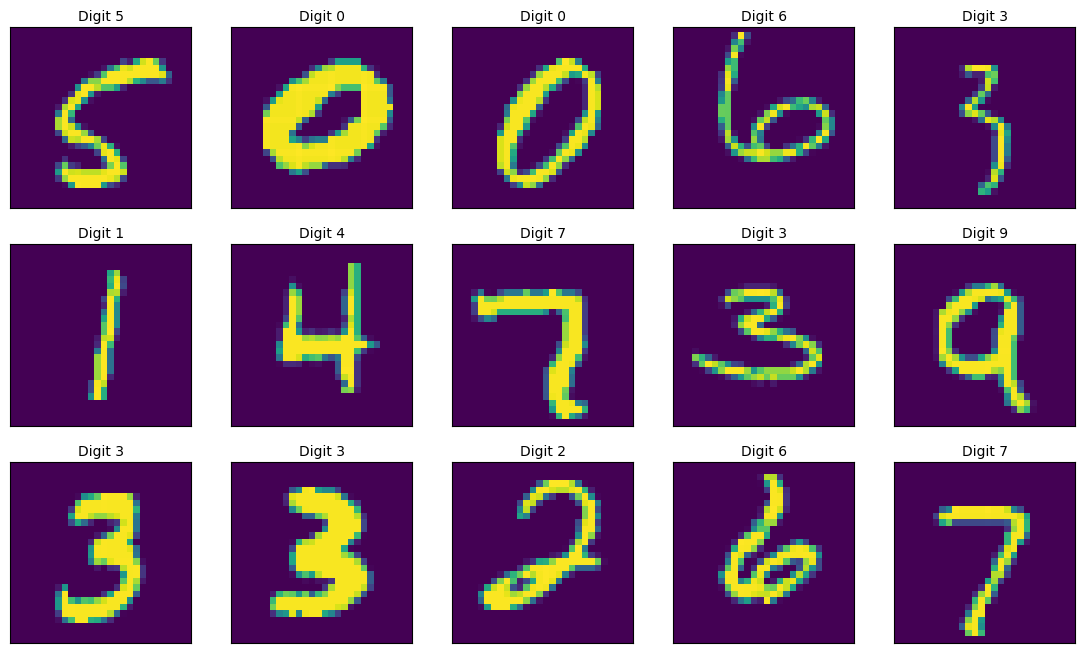

In [10]:
# View a few training data examples

import numpy as np
import matplotlib.pyplot as plt

n_rows, n_cols = 3, 5
random_inx = np.random.choice(x_train.shape[0], n_rows * n_cols, replace=False)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

for n, i in enumerate(random_inx):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(x_train[i])
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].text(10., -1.5, f'Digit {y_train[i]}')
plt.show()

In [11]:
# Create an MNIST classifier model
from keras.layers import Flatten

mnist_model = Sequential([
    Flatten(input_shape = (28,28)),
    Dense(64, activation = "tanh"),
    Dense(64, activation = "tanh"),
    #one neuron for each class
    Dense(10, activation = "softmax")
])

mnist_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                50240     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
Total params: 55050 (215.04 KB)
Trainable params: 55050 (215.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


To train the model, we need to specify a loss function to minimise, and an optimisation algorithm. The average negative log-likelihood on the training set is given by the categorical cross entropy

$$
L(\theta) = -\frac{1}{|\mathcal{D}_{train}|} \sum_{x_i\in\mathcal{D}_{train}}\sum_{j=1}^{10} \tilde{y}_{ij} \ln f_\theta(x_i)_j,
$$

where $f_\theta$ is the neural network function (with parameters $\theta$) that outputs a length 10 probability vector $f_\theta(x_i)\in\mathbb{R}^{10}$ for an input example image $x_i\in\mathbb{R}^{28\times 28}$, and $\tilde{y}_{ij}$ is 1 if the correct label for example $i$ is $j$, and 0 otherwise.

As our labels `y_train` and `y_test` are in sparse form, we use the `sparse_categorical_crossentropy` loss function. We also will use the stochastic gradient descent (SGD) optimiser.

In [12]:
# Compile the model
#categorical_crossentropy would be for a 10 vector with 0s and a 1 in the corresonding class
#but we have sparse labels, just an integer for each
#optimise with sgd
#can specify metrics that we want to see
mnist_model.compile(loss = "sparse_categorical_crossentropy",optimizer = "sgd", metrics = ["accuracy"])

The image data is filled with integer pixel values from 0 to 255. To facilitate the training, we rescale the values to the interval $[0, 1]$.

In [13]:
# Rescale the image data
x_train = x_train / 255.
x_test = x_test / 255.


In [14]:
# Train the model
#epoch is complete pass through the training set

history = mnist_model.fit(x_train,y_train, epochs = 10, batch_size = 64)


Epoch 1/10
938/938 [==============================] - 4s 4ms/step - loss: 0.8667 - accuracy: 0.7879
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.4224 - accuracy: 0.8886
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.3503 - accuracy: 0.9036
Epoch 4/10
938/938 [==============================] - 3s 4ms/step - loss: 0.3147 - accuracy: 0.9113
Epoch 5/10
938/938 [==============================] - 3s 4ms/step - loss: 0.2907 - accuracy: 0.9174
Epoch 6/10
938/938 [==============================] - 3s 4ms/step - loss: 0.2722 - accuracy: 0.9225
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.2568 - accuracy: 0.9263
Epoch 8/10
938/938 [==============================] - 4s 4ms/step - loss: 0.2436 - accuracy: 0.9311
Epoch 9/10
938/938 [==============================] - 4s 4ms/step - loss: 0.2315 - accuracy: 0.9347
Epoch 10/10
938/938 [==============================] - 4s 4ms/step - loss: 0.2207 - accuracy: 0.9375

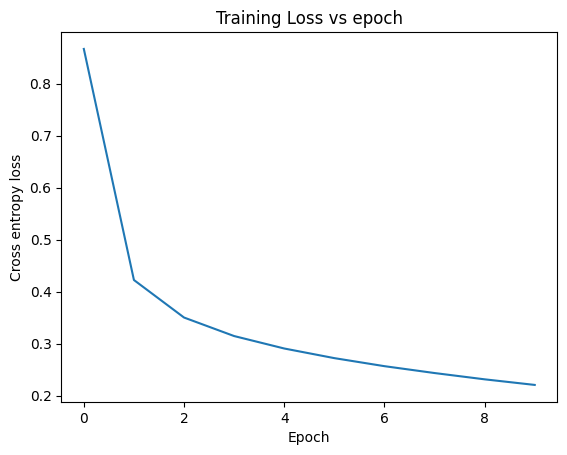

In [15]:
# Plot the learning curve

plt.plot(history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Training Loss vs epoch")
plt.show()

In [16]:
# Evaluate the model on the test set

#actually evaluate 
mnist_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.2123 - accuracy: 0.9375


[0.21226371824741364, 0.9375]

In [18]:
# Get predictions from model
preds = mnist_model.predict(x_test)
preds.shape


313/313 [==============================] - 1s 4ms/step


(10000, 28, 28)

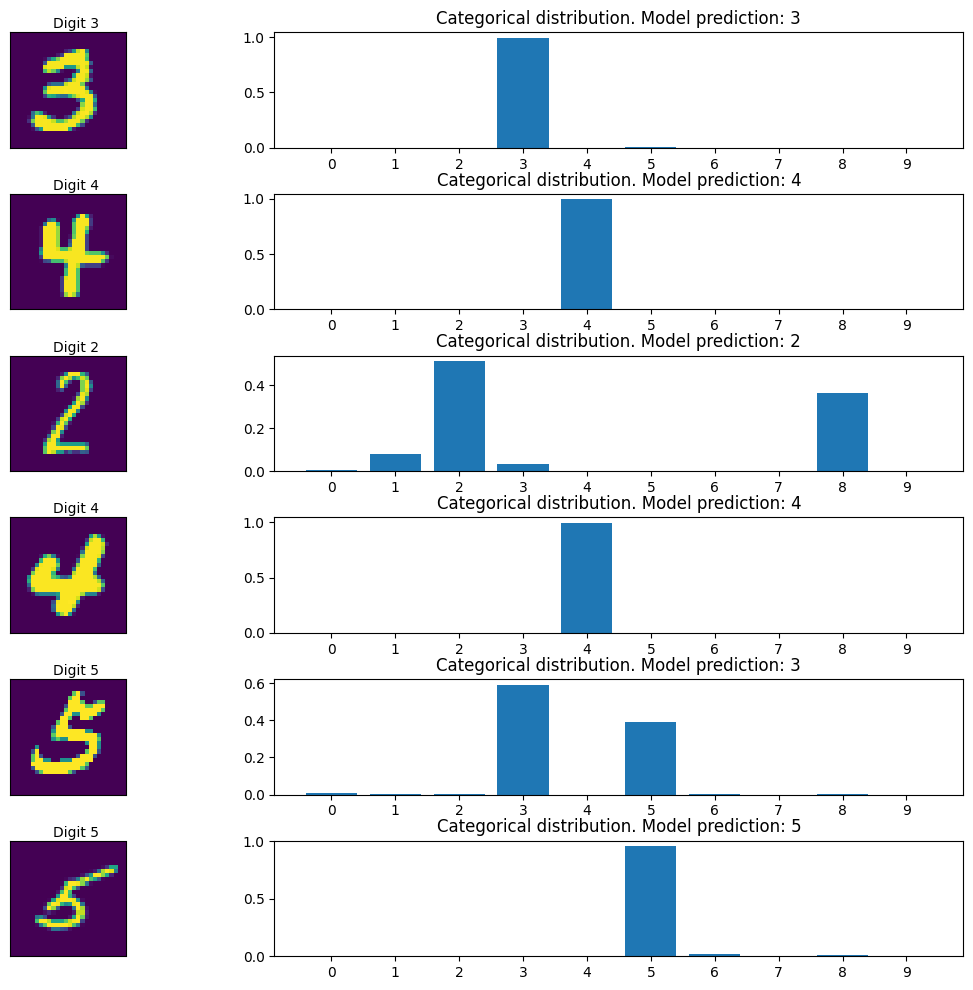

In [24]:
# Plot some predicted categorical distributions

num_test_images = x_test.shape[0]

random_inx = np.random.choice(num_test_images, 6)
random_preds = preds[random_inx, ...]
random_test_images = x_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

fig, axes = plt.subplots(6, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(random_preds, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
plt.show()

*Exercise.* The MNIST dataset is an easy dataset, and the above model is far from optimal. Try experimenting with longer training times and/or model architecture changes to see if you can improve on the performance.

<a class="anchor" id="references"></a>
### References

<a class="anchor" id="Clevert16"></a>
* Clevert, D.-A., Unterthiner, T., & Hochreiter, S. (2016), "Fast and Accurate Deep Network Learning by Exponential Linear Units (ELUs)", in *4th International Conference on Learning Representations, {ICLR} 2016", San Juan, Puerto Rico, May 2-4, 2016.
<a class="anchor" id="Klambauer17"></a>
* Klambauer, G., Unterthiner, T., Mayr, A., & Hochreiter, S. (2017), "Self-Normalizing Neural Networks", *Neural Information Processing Systems (NIPS)*, 971-980.
<a class="anchor" id="McCullochPitts43"></a>
* McCulloch, W. & Pitts, W. (1943), "A Logical Calculus of Ideas Immanent in Nervous Activity", Bulletin of Mathematical Biophysics, **5**, 127-147. 
<a class="anchor" id="Ramachandran18"></a>
* Ramachandran, P., Zoph, B. & Le, Q. V. (2018) "Searching for Activation Functions", arXiv preprint, abs/1710.05941.
<a class="anchor" id="Robbins51"></a>
* Robbins, H. and Monro, S. (1951), "A stochastic approximation method", *The annals of mathematical statistics*, 400–407.
<a class="anchor" id="Rosenblatt58"></a>
* Rosenblatt, F. (1958), "The Perceptron: A Probabilistic Model for Information Storage and Organization in The Brain", Psychological Review, 65-386.
<a class="anchor" id="Rosenblatt61"></a>
* Rosenblatt, F. (1961), "Principles of Neurodynamics. Perceptrons and the Theory of Brain Mechanisms", Defense Technical Information Center.
<a class="anchor" id="Rumelhart86a"></a>
* Rumelhart, D. E., McClelland, J. L. and the PDP Research Group (1986a), "Parallel Distributed Processing: Explorations in the Microstructure of Cognition", MIT Press, Cambridge.
<a class="anchor" id="Rumelhart86b"></a>
* Rumelhart, D. E., Hinton, G., & Williams, R. (1986b), "Learning representations by back-propagating errors", Nature, **323**, 533-536.